In [1]:
import os,sys, operator
import shutil, gzip, math
import pickle
import numpy as np                                       # fast vectors and matrices
from glob import glob
from time import time
import matplotlib.pyplot as plt

import tensorflow as tf

import torch
from torch.utils.data import DataLoader
from torch import optim
from torch import tensor
from torch import nn
import torch.nn.functional as F
from torch import nn

from pathlib import Path
from IPython.core.debugger import set_trace
from collections import Counter

%matplotlib inline

## Data Loader

In [2]:
from torch.utils.data import Dataset

In [6]:
train_feat_path="processed_dataset\\train\\feat\\"
train_label_path="processed_dataset\\train\\label\\"
test_feat_path="processed_dataset\\test\\feat\\"
test_label_path="processed_dataset\\test\\label\\"

train_name=os.listdir(train_feat_path)
test_name=os.listdir(test_feat_path)

class CustomTrainDataset(Dataset):
    def __init__(self, feat_path=train_feat_path , label_path=train_label_path , transform=None, target_transform=None):
        self.img_labels = os.listdir(train_feat_path)
        self.feat_path = feat_path 
        self.label_path = label_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        data = (torch.from_numpy(np.load(self.feat_path +self.img_labels[idx])))
        label = (torch.from_numpy(np.load(self.label_path +self.img_labels[idx])))
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

class CustomTestDataset(Dataset):
    def __init__(self, feat_path=test_feat_path , label_path=test_label_path , transform=None, target_transform=None):
        self.img_labels = os.listdir(train_feat_path)
        self.feat_path = feat_path 
        self.label_path = label_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        data = (torch.from_numpy(np.load(self.feat_path +self.img_labels[idx])))
        label = (torch.from_numpy(np.load(self.label_path +self.img_labels[idx])))
        print(self.feat_path +self.img_labels[idx])
        return data, label
    
    def demo() :
        for indices in train :
            yield collate_fn(train_dataset[i] for i in indices)


In [7]:
train_dataset=CustomTrainDataset()
test_dataset=CustomTrainDataset()

## model

In [8]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        time= 1500
        batch = 32
        
        self.lstm_unit = 128
        self.karnel= 3
        self.stride = 5
        feat = [120, 118, 256, 88]

        #self.layers = [ nn.Conv1d( 1500, 1500, kernel_size) ] #, nn.ReLU()]
        self.convo1 = nn.Conv1d( 120, 100, 3, padding='same')  # ลอง padding="same" เพื่อให้ time เท่าเดิมครับ
        self.convo2 = nn.Conv1d( 1500, 1000, 5, padding='same') 
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=100, hidden_size=44, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=998, hidden_size=128, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(998,1500 , bias=True)

    def __call__(self, x):
        x = normalized(x)  # ควรมาใส่ตรงนี้คับ
        #x = self.convo2(x)  # <-- อันนี้ไม่ต้องครับ
        x = torch.transpose(x, 0, 1)  # reformat from (B, T, C) to (B, C, T)
        x = self.convo1(x)   # (B, C=120, T=1500) -> (B, C=conv1_out_dim, T=1500)
        x= self.relu(x)
        # เพิ่ม conv2 จากนี้ก้ได้คับ
        #x = self.relu(x)
       
        x = torch.transpose(x, 0, 1)  # convert (B, C, T) -> (B, T, C)
        x, _ = self.lstm(x)  # lstm
        return x

def normalized(data):
    return (data - data.mean(1, keepdims=True)) / data.std(1, keepdims=True)

In [ ]:
x,y = next(iter(train))

model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
xy =model(x[0])
temp=x[0]
ans_temp=xy

In [9]:
loss_f = nn.MSELoss()
def normalized(data): 
    return (data - data.min()) / (data.max()-data.min())

def M_accuracy(yhat, y):
    predictions = yhat.detach().numpy()
    true_values = y.detach().numpy()
    correct = (predictions >= 0.5) == true_values
    return correct.mean().item()

    predictions = (predictions >=0.5) 
    correct = ((predictions >=0.5) == true_values)
    return correct.mean().item()

def M_loss_func(yhat,y):
    '''
    predictions = yhat
    true_values = ((1/2)*y )+0.5
    '''
    #temp = torch.ones(1500, 88 , requires_grad=True) / 2
    predictions = yhat
    true_values = y
    return loss_f(true_values, predictions) #*128/2.

## loop

In [10]:
from torch.utils.data import DataLoader
batch = 32
train = DataLoader(train_dataset, batch_size=batch, shuffle=True)
test = DataLoader(test_dataset, batch_size=batch, shuffle=True)
epoch = len(train)

In [11]:
def get_epoch(k):
    print("epoch","\t train loss \t accuracy \t\t val loss")
    train_loss ,train_acc, val_loss=0,0,0
    for i in range(0,k) :
        train_epoch(i)

def train_epoch(k):
    x,y =next(iter(train))
    train_batch_loss = []
    train_batch_acc = []
    for i in range(batch) :
        xb=x[i].to(device)
        yb=y[i].to(device)
        optimizer.zero_grad()
        
        yhatb = model(xb)
        loss = M_loss_func(yhatb, yb)
        acc = M_accuracy(yhatb, yb)
               
        
        loss.backward()
        optimizer.step()

        train_batch_loss.append(loss.detach().cpu().numpy())
        train_batch_acc.append(acc)
        baseline_mse = M_loss_func(torch.zeros_like(yb), yb)

        losses.append(loss.detach().cpu().numpy()),metrics.append(acc)
        baseline.append(baseline_mse)  

    train_loss = np.mean(train_batch_loss)  # average train loss among all batches
    train_acc = np.mean(train_batch_acc)  # average acc among all batches     

    val_batch_loss = []
    xx,yy =next(iter(test))
    for i in range(batch) :
        xb=xx[i].to(device)
        yb=yy[i].to(device)
        
        # we don't need to calculate gradients when evaluating
        with torch.no_grad():
            yhatb = model(xb)  # forward propagation
            loss = M_loss_func(yhatb, yb)  # compute val loss
        val_batch_loss.append(loss.cpu().numpy())
    
    val_loss = np.mean(val_batch_loss)
    print(k, "\t", train_loss , "\t", train_acc,"\t", val_loss, "\t" , yhatb.mean())

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Model()
model = model.to(device)
#model.load_state_dict(torch.load("weight/convo1/mymodel.pt"))

In [ ]:
losses, metrics, baseline = [], [], []

lr=3e-4
optimizer = torch.optim.Adam(model.parameters(), lr)
model=Model()
#model.load_state_dict(torch.load("weight/linear/mymodel.pt"))
get_epoch(10)
torch.save(model.state_dict(), "weight/linear/mymodel.pt")

In [24]:
with open('weight/convo1/baseline_log.pkl', 'rb') as f:
    baseline_log = pickle.load(f)
with open('weight/convo1/loss_log.pkl', 'rb') as f:
    loss_log = pickle.load(f)
with open('weight/convo1/acc_log.pkl', 'rb') as f:
    acc_log = pickle.load(f)
with open('weight/convo1/lr_log.pkl', 'rb') as f:
    lr_log = pickle.load(f)

lr = 10e-4/2./2/2/2/2
for k in losses :
    loss_log.append(float(k))
for i in range(len(baseline)) :
    lr_log.append(lr)
acc_log = acc_log + metrics
baseline_log = baseline_log + baseline

## Graph Represent

In [18]:
lr = 10e-4/2./2/2/2/2
loss_log=[]
lr_log=[]
acc_log=[]
baseline_log=[]
for k in losses :
    loss_log.append(float(k))
for i in range(len(baseline)) :
    lr_log.append(lr)
acc_log = acc_log + metrics
baseline_log = baseline_log + baseline

<ipython-input-19-867ec72a6036>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


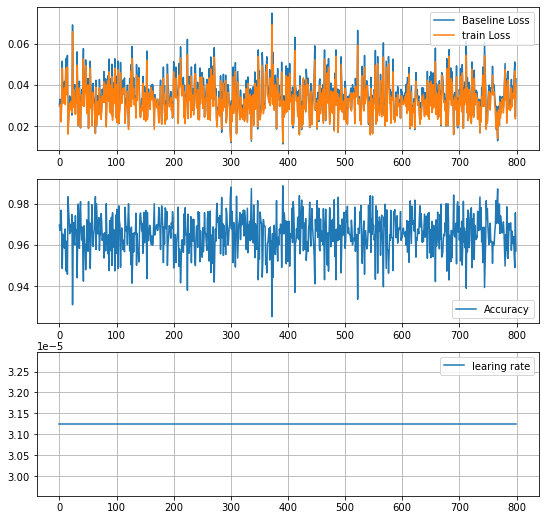

In [19]:
x = torch.arange(len(acc_log)).numpy()
fig,ax = plt.subplots(3,1,figsize=(9, 9))

#0 = loss & baseline
#1 = Accuracy
#2 = learing rate

ax[0].plot(x, baseline_log, label="Baseline Loss")
ax[0].plot(x, loss_log, label="train Loss")
ax[1].plot(x, acc_log, label="Accuracy")
ax[2].plot(x, lr_log, label="learing rate")

for k in ax :
    k.legend()
    k.grid(True)


fig.show()

In [20]:
with open('weight/convo1/baseline_log.pkl', 'wb') as f:
    pickle.dump(baseline_log, f)
with open('weight/convo1/loss_log.pkl', 'wb') as f:
    pickle.dump(loss_log, f)
with open('weight/convo1/acc_log.pkl', 'wb') as f:
    pickle.dump(acc_log, f)
with open('weight/convo1/lr_log.pkl', 'wb') as f:
    pickle.dump(lr_log, f)

## TEST

In [29]:
batch = 16
test = DataLoader(test_dataset, batch_size=batch, shuffle=True)

In [31]:
def get_test_epoch(k):
    for i in range(0,k) :
        test_epoch()

def test_epoch():
    x,y =next(iter(test))
    for i in range(batch) :
        xb=x[i]
        yb=y[i]
        yhatb = model(xb)
        acc = M_accuracy(yhatb, yb)    
        metrics_test.append(acc)

In [16]:
metrics_test=[]
get_test_epoch(4)

In [17]:
print( "accuracy : ", sum(metrics_test)/len(metrics_test))

accuracy :  0.9636137547348482


In [32]:
x,y = next(iter(test))
xy=model(x[0])

In [43]:
tx = xy.detach().numpy()
ty = y[0].detach().numpy()
tx = 1*(tx>=0.5)

In [34]:
check = 1*(tx==ty)
check[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [35]:
check.mean()

0.9682348484848485

In [45]:
xy = 1*(xy>=tx.mean())

In [37]:
xy.size()

torch.Size([1500, 88])

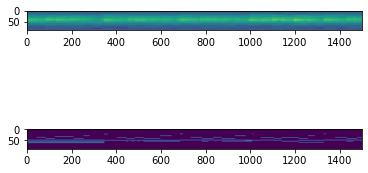

In [36]:
fig,ax = plt.subplots(2,1)
k = torch.transpose(xy, 0,1).detach().numpy()
ax[0].imshow(k)
ky = torch.transpose(y[0], 0,1).detach().numpy()
ax[1].imshow(ky)
plt.show()

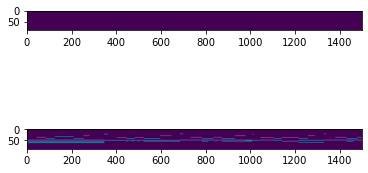

In [46]:
fig,ax = plt.subplots(2,1)
k = torch.transpose(xy, 0,1).detach().numpy()
ax[0].imshow(k)
ky = torch.transpose(y[0], 0,1).detach().numpy()
ax[1].imshow(ky)
plt.show()

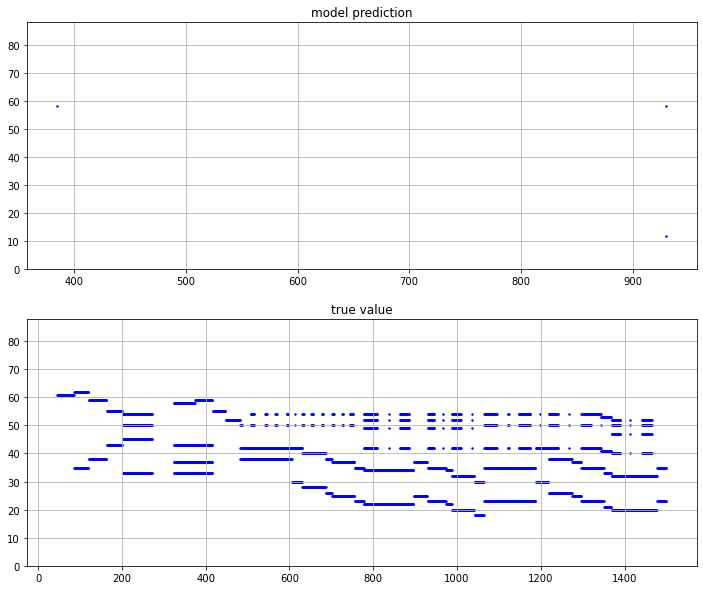

In [23]:
id=0
x=np.arange(0,len(tx[id]))
fig,ax = plt.subplots(2,1)
ax[0].grid(), ax[1].grid()
ax[0].set_ylim(0, 88)
ax[1].set_ylim(0, 88)

fig.set_figwidth(12)
fig.set_figheight(10)

ax[0].set_title('model prediction')
for i in range(1500):
    for j in range(88) :
        if(tx[i][j]==1) :
            ax[0].scatter(i,j, s=2,c="b") 

ax[1].set_title('true value')
for i in range(1500):
    for j in range(88) :
        if(ty[i][j]==1) :
            ax[1].scatter(i,j, s=2,c="b") 

plt.show()

In [71]:
#วัดตัวที่ทายผิดใน epoch test

N=np.array([])
for i in range(batch) :
    ct=0;
    for j in range(1500) :
        for k in range(88) : 
            if(xy[i][j][k] != y[i][j][k]) :
                ct+=1    
    N=np.append(N,ct)

print(N.mean())

88.0


In [75]:
#วัดตัวที่ทาย 1 เป็น 0 ใน epoch test
K=np.array([])
for i in range(batch) :
    for j in range(1500) :
        ct,CT =0,0;
        for k in range(88) : 
            if y[i][j][k]==1 :
                CT+=1
                if(xy[i][j][k]==0) :
                    ct+=1
        if(CT==0) :
            if(ct==0) : K=np.append(K,0)
            else : K=np.append(K,ct)
        else : K=np.append(K,ct/CT)

print(K.mean())

0.0
